# Telecom Costumer Churn

## Objective

This project on behalf of "Interconnect" (telecom operator) is developing a model to forecast costumer churn. If a client is expected to leave according to model predictions
they will be offered promotional codes or special plan options. 

Main services to monitor offered by Interconnect are:

- **Landline communication:** Telephone service that can be connected to several lines simultaneously.
- **Internet:** Network that can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Clients have the option to enter a monthly or 1-2 year contract. Payments can be made thourgh several methods and clients recieve an electronic invoice after each transaction. 

### Data Description

Data contains files from different client sources:

`contract.csv` - client contact information

`personal.csv` - client personal data

`internet.csv` - information regarding internet services

`phone.csv` - information about telephone services

Each file contains a `costumerID` column that assigns a unique code to each client. 

Contract information is valid as of Feb 1, 2020.

**Target feature:** `EndDate` column when equal to `No`

**Primary Metric:** AUC-ROC.

**Additional Metric:** Accuracy

### Import tools

In [64]:
import numpy as np
import pandas as pd
import warnings

import math
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.preprocessing 
import lightgbm as lgb
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from functools import reduce
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
import warnings

### Load data

In [65]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
contract = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

### General notes on data

In [ ]:
print("Number of clients who have not ended contract:", contract.query("EndDate == 'No'").groupby('customerID')['customerID'].sum().count())
print("Client percentage who has not ended contract:", len(contract[contract['EndDate'] == "No"]) / len(contract['EndDate']))

1. Numbers show approximately 73% of clients in the dataset not ended their contract therefore we will need to conduct some balancing in the data before training.

2. The four datasets available show most object type features to be binary options.

3. The contract dataset shows several features (ex.`paymentmethod`, `type`) to have more than two options, enconding is required.

4. No missing values appear in datasets

## Proposed Work Plan

### Data Preprocessing

The four datasets available show most object type features to be binary options.

1. Change column headings to lowercase.

2. Correct required datatypes:
    - `begindate` to datetime - contract dataset.
    - `totalcharges` to float - contract dataset.
          
4. Change binary option features in columns to 0 and 1 respectively.

5. One-hot-encode required columns:
    - `paymentmethod`, `type` - contract data set

7. Create column with binary options of clients who have and have not ended their contract
    - Drop enddate column.

9.  Merge dataframes into one main dataset.

### EDA

1. Check contract status and charges ratios
   
2. Check for seasonatilty

### Feature Engineerinng

1. Split the data into train, validation and test sets.
   
2. Fix class imbalance.
   - upscale data.
    
3. Scale (`monthlycharges`, `totalcharges`) in data.
   - maxabscaler - perserve sparsity

### Training

- Validation metric: Accuracy, AUC-ROC.

1. Train baseline model for metric comparision
   - Logistic regression

2. Train diverse boosting algorithims and tune for desired metrics.
    - XGBoost
    - LightGBM
    - Catboost

3. Evaluate validation data
    - Plot and compare models

3. Evaluate test sets
    - Plot and compare results

### Report Conclusions

1. Offer conclusions and select best model for task.

### Preprocess data

In [66]:
# Change column names to lowercase 
personal = personal.rename(str.lower, axis='columns')
contract = contract.rename(str.lower, axis='columns')
internet = internet.rename(str.lower, axis='columns')
phone = phone.rename(str.lower, axis='columns')

In [67]:
# Change begindate to datetime
contract['begindate'] = pd.to_datetime(contract['begindate'], format='%Y-%m-%dT')

In [68]:
# Change total charge data type to float
contract['totalcharges'] = pd.to_numeric(contract.totalcharges, errors='coerce')

In [69]:
# Replace binary options in columns with 0 and 1
personal.replace(to_replace=['Male', 'Female', 'No', 'Yes'], value=[0, 1, 0, 1], inplace=True)
contract['paperlessbilling'].replace(to_replace=['No', 'Yes'], value=[0 , 1], inplace=True)
internet.replace(to_replace=['DSL', 'Fiber optic', 'No', 'Yes'], value=[0, 1, 0, 1], inplace=True)
phone.replace(to_replace=['No', 'Yes'], value=[0, 1], inplace=True)

In [70]:
# Generate contract status feature
def contract_status(status):

    if status == "No":
        return 0
    else:
        return 1
    
contract['churn'] = contract['enddate'].apply(contract_status)

In [71]:
# One-hot-encode features
contract_ohe = pd.get_dummies(contract, columns = ['type', 'paymentmethod'])
contract_copy = contract_ohe.copy()

In [72]:
# Create single main dataframe
dataframes = [personal, contract_copy, internet, phone]
data_main = reduce(lambda left,right: pd.merge(left, right, on=['customerid'], how='outer'), dataframes).fillna('unknown')

In [73]:
# Adjust datatypes in main dataframe
columns_num = ['totalcharges', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
data_main[columns_num] = data_main[columns_num].apply(pd.to_numeric, errors='coerce')

In [74]:
# Remove unecessary columns for training
data_main = data_main.drop('begindate', axis=1)
data_main = data_main.drop('enddate', axis=1)
data_main = data_main.drop('customerid', axis=1)

## EDA

In [ ]:
# PLot contract status
changes_year = contract.groupby(['customerid', 'status', contract.begindate.dt.year])['totalcharges'].sum().reset_index()
changes_year.columns = ['customerid', 'status', 'year', 'totalcharges']
active = changes_year.query("status == 0").groupby('year')['totalcharges'].mean().reset_index()
non_active = changes_year.query("status == 1").groupby('year')['totalcharges'].mean().reset_index()

In [ ]:
yearly_average_charges = pd.merge(active[['year','totalcharges']], non_active[['year','totalcharges']], on = 'year')
yearly_average_charges['year'] = yearly_average_charges['year'].astype('object')
yearly_average_charges.columns = ['year', 'active', 'non_active']

yearly_average_charges.plot(x='year', kind='bar',
                           title="Average yearly charges ",
                           ylabel="Average charges)",
                           figsize=(8,6))

plt.legend(['active', 'non active'])
plt.xticks(rotation=45)
plt.show()

Average yearly charges per client show active clients actually spend less a year than clients that have ended their contract.

In [ ]:
# Check for seasonality
data_seasonal = pd.DataFrame(data=data_main[['begindate', 'monthlycharges']])
data_seasonal.set_index('begindate', inplace=True)
data_seasonal.sort_index(inplace=True)
decomp = seasonal_decompose(data_seasonal, period=1)
decomp.plot()
plt.show()

Seasonal decompose shows there to be no discernable yearly seasonality in customer spending. 

### Feature Engineering

Class imbalance is handled using upsampling.

In [75]:
# Split data
features = data_main.drop('churn', axis=1)
target = data_main['churn']

features_train_valid, features_test, target_train_valid, target_test = train_test_split(features, target,  test_size = 0.2, random_state = 12345, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid, target_train_valid, test_size = 0.25, random_state = 12345, stratify=target_train_valid)

In [76]:
print(f"Train set class frequency: {len(target_train[target_train == 1]) / len(target_train):.2f}")
print(f"Test set class frequency: {len(target_test[target_test == 1]) / len(target_test):.2f}")        

Train set class frequency: 0.27
Test set class frequency: 0.27


In [77]:
# Handle NaN values replacing with mean
features_train = features_train.fillna(features_train.mean())
features_valid = features_valid.fillna(features_train.mean())
features_test = features_test.fillna(features_train.mean())

In [78]:
# Scale Data
scale_columns = ['monthlycharges', 'totalcharges']

def scale_data(train_data, valid_data, test_data, scale_columns):
    scaler_mas = sklearn.preprocessing.MaxAbsScaler().fit(train_data[scale_columns].to_numpy())
    
    train_scaled = train_data.copy()
    train_scaled.loc[:, scale_columns] = scaler_mas.transform(train_data[scale_columns].to_numpy())

    valid_scaled = valid_data.copy()
    valid_scaled.loc[:, scale_columns] = scaler_mas.transform(valid_data[scale_columns].to_numpy())
    
    test_scaled = test_data.copy()
    test_scaled.loc[:, scale_columns] = scaler_mas.transform(test_data[scale_columns].to_numpy())
    
    return train_scaled, valid_scaled, test_scaled
    
features_train_scaled, features_valid_scaled, features_test_scaled = scale_data(features_train, features_valid, features_test, scale_columns)

In [79]:
# scale data
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_sampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_sampled, target_sampled = shuffle(features_sampled, target_sampled, random_state=12345)

    return features_sampled, target_sampled

features_train_sampled, target_train_sampled = upsample(features_train_scaled, target_train, 10)

In [80]:
display(features_train_sampled.shape)
display(target_train_sampled.shape)

(14314, 22)

(14314,)

# Training

Create evaluation procedure for trained models. Because target is binary classification, **accuracy**, **roc-auc score**, **F1 score** and **average precision score** are evaluated as well. This offers a more detailed analysis of prediction rates for classes and probabilities. 

In [81]:
# Evaluation function
def evaluate_model(best_model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = best_model.predict(features)
        pred_proba = best_model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Logistic Regression - Baseline

In [121]:
%%time

# Train logistic regression
model_LR = LogisticRegression(class_weight='balanced', solver='liblinear')
model_LR.fit(features_train_sampled, target_train_sampled)

predictions_LR = model_LR.predict(features_valid_scaled)
LR_accuracy = sklearn.metrics.accuracy_score(target_valid, predictions_LR)
LR_roc_auc = metrics.roc_auc_score(target_valid, predictions_LR)
print(f"Logistic Regression Accuracy: {LR_accuracy.round(2)}\n")
print(f"Logistic Regression roc_auc score: {LR_roc_auc.round(2)}\n")

Logistic Regression Accuracy: 0.75

Logistic Regression roc_auc score: 0.76

CPU times: user 47.5 ms, sys: 1.84 ms, total: 49.3 ms
Wall time: 36.1 ms


### Random Forest Classifier

In [83]:
%%time

# Train for random forest regressor 
model_RFR = RandomForestClassifier(random_state = 12345)

search_RFR = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 9]}

GS_RFR = GridSearchCV(estimator = model_RFR,
                     param_grid = search_RFR,
                     scoring = ['accuracy', 'roc_auc'],
                     refit = 'roc_auc',
                     verbose = 0)

GS_RFR.fit(features_train_sampled, target_train_sampled)

In [84]:
best_RFR = GS_RFR.best_estimator_

In [85]:
evaluate_model(best_RFR, features_train_sampled, target_train_sampled, features_valid_scaled, target_valid)

### Catboost

In [114]:
%%time

# Train CatBoost
model_CB = CatBoostClassifier(verbose=False, random_state=12345)

search_CB = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1.0],
}

GS_CB = GridSearchCV(estimator = model_CB, 
                    param_grid = search_CB,
                    scoring = ['accuracy', 'roc_auc'],
                    refit = 'roc_auc',
                    cv = 5)

GS_CB.fit(features_train_sampled, target_train_sampled, eval_set=(features_valid_scaled, target_valid))

CPU times: user 3min 53s, sys: 46.2 s, total: 4min 39s
Wall time: 2min 22s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fe87c758df0>,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [200, 300, 500]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [115]:
CB_best = GS_CB.best_estimator_

          train  test
Accuracy   0.96  0.74
F1         0.98  0.62
APS        0.99  0.66
ROC AUC    0.98  0.84


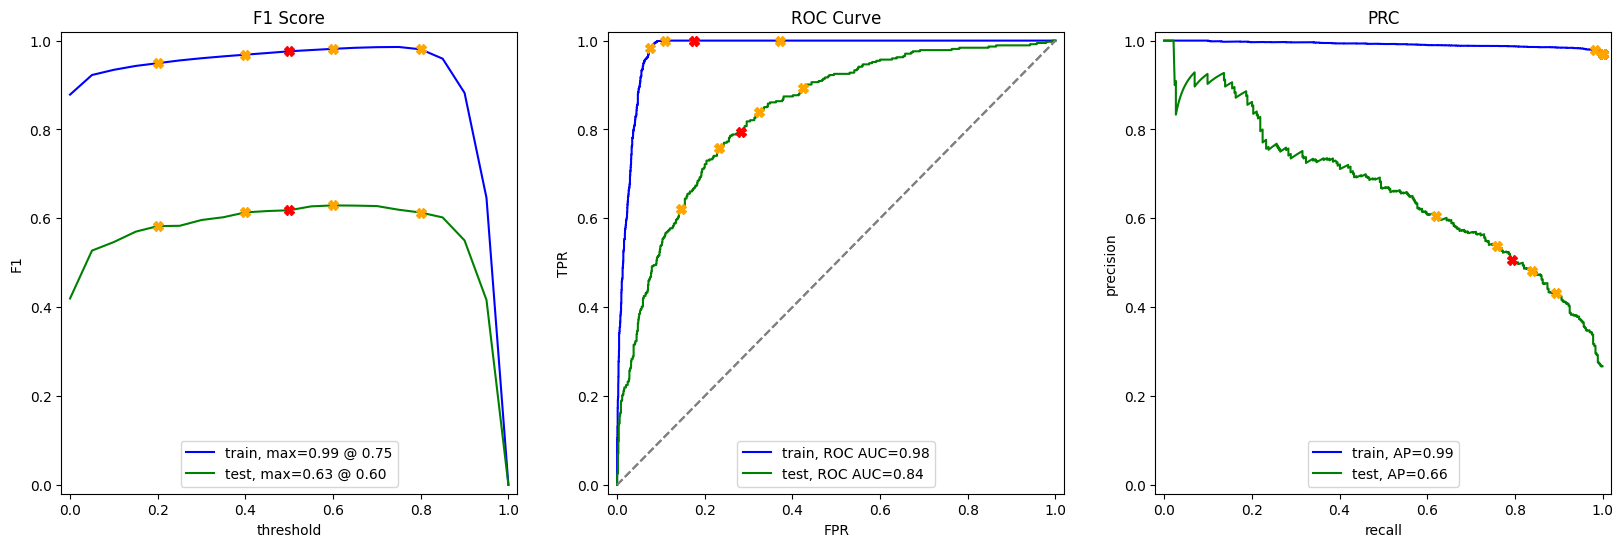

In [116]:
evaluate_model(CB_best, features_train_sampled, target_train_sampled, features_valid_scaled, target_valid)

### LightGBM

In [53]:
%%time

# Train LightGBM
model_LGBM = lgb.LGBMClassifier(random_state = 12345)

search_LGBM = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.001, 0.01, 0.1, 1.0]}

GS_LGBM = GridSearchCV(estimator = model_LGBM,
                        param_grid = search_LGBM,
                        scoring = ['accuracy', 'roc_auc'],
                        refit = 'roc_auc',
                        cv = 5)

GS_LGBM.fit(features_train_sampled, target_train_sampled, callbacks=[log_evaluation(period=0)], eval_set=(features_valid_scaled, target_valid))

CPU times: user 2min 39s, sys: 0 ns, total: 2min 39s
Wall time: 1min 19s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=12345),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [200, 300, 500]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [54]:
LGBM_best = GS_LGBM.best_estimator_

          train  test
Accuracy   0.99  0.76
F1         1.00  0.60
APS        1.00  0.63
ROC AUC    1.00  0.82


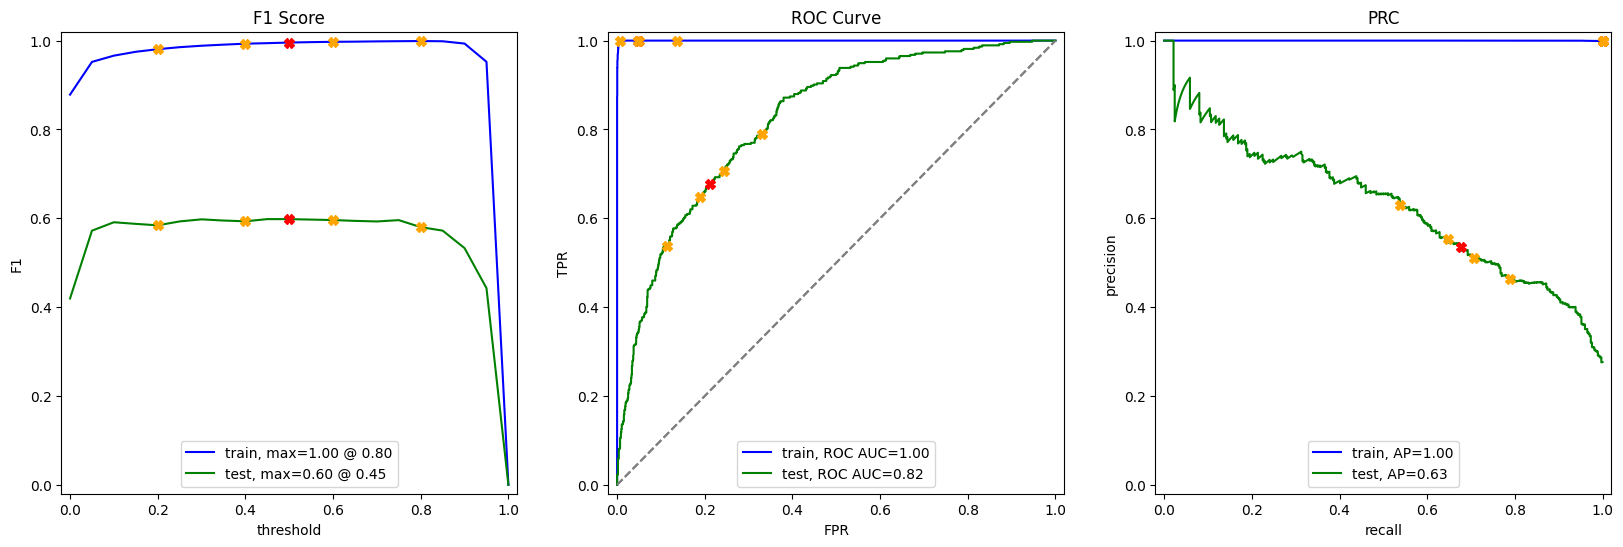

In [55]:
evaluate_model(LGBM_best, features_train_sampled, target_train_sampled, features_valid_scaled, target_valid)

### XGBoost

In [56]:
%%time

# Train XGBoost
model_XGB = xgb.XGBClassifier(verbosity = 0, random_state = 12345)

search_XGB = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.001, 0.01, 0.1, 1.0]}

GS_XGB = GridSearchCV(estimator = model_XGB, 
                      param_grid = search_XGB,
                      scoring = ['accuracy', 'roc_auc'],
                      refit = 'roc_auc',
                      cv = 5)
                      
GS_XGB.fit(features_train_sampled, target_train_sampled, eval_set = [(features_valid_scaled, target_valid)], verbose=0)

CPU times: user 15min 40s, sys: 249 ms, total: 15min 40s
Wall time: 7min 51s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=12345, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

In [57]:
XGB_best = GS_XGB.best_estimator_

          train  test
Accuracy    1.0  0.77
F1          1.0  0.56
APS         1.0  0.58
ROC AUC     1.0  0.79


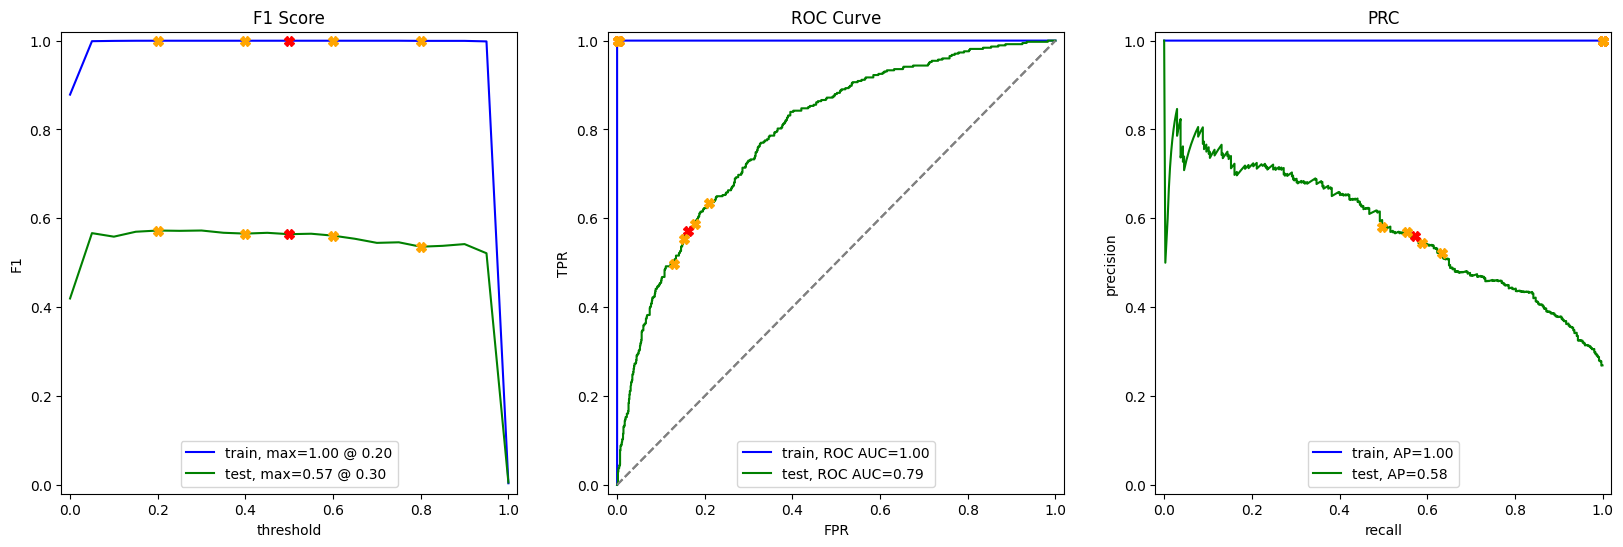

In [58]:
evaluate_model(XGB_best, features_train_sampled, target_train_sampled, features_valid_scaled, target_valid)

### Testing

Based on model evaluations CatBoost appears to be most effective model for prediction.

          train  test
Accuracy   0.96  0.72
F1         0.98  0.60
APS        0.99  0.61
ROC AUC    0.98  0.81


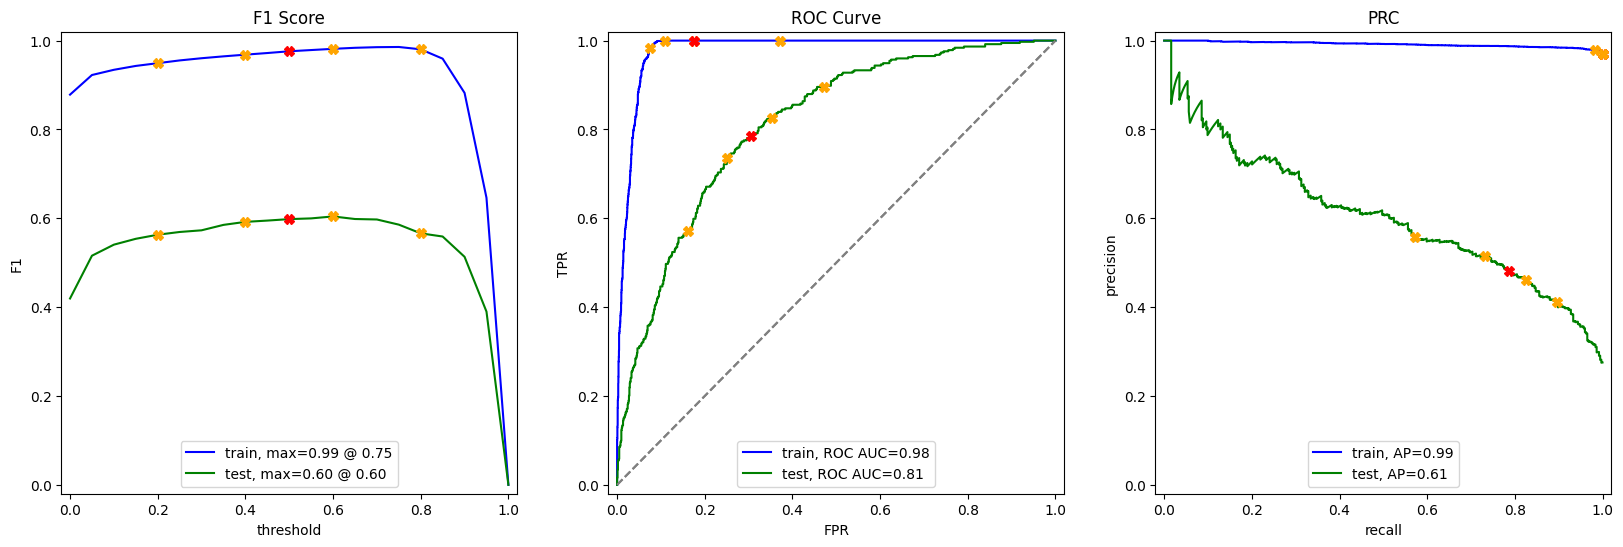

In [118]:
# Evaluate test data
evaluate_model(CB_best, features_train_sampled, target_train_sampled, features_test_scaled, target_test)

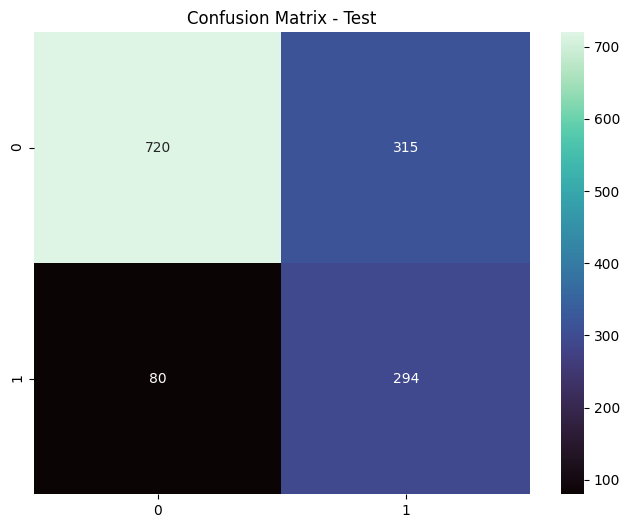

In [119]:
# Plot predictions confusion matrix
pred_XGB = CB_best.predict(features_test_scaled)
cm = metrics.confusion_matrix(target_test, pred_XGB, labels=[0, 1])
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot=True, fmt='', cmap='mako')
plt.title("Confusion Matrix - Test")
plt.show()

# Conclusions Report

Costumer churn prediction project consisted of an analysis and training pipeline that followed outlined steps:

- **Data Preprocessing:** Preprocessing entailed correction of data types, value replacement for binary options, encoding of required columns with more then two options,
  dropping unecessary columns, as well as merging datasets into one. All steps of preprocessing were carried out however, general overview of data revealed <u>class imbalance</u> in   data.
  
- **EDA:** Exploratory analysis showed clients with contract no longer active appear to spend more every year then those with active service. Analysis shows no apparent
  seasonality in data in relation to customer habits.

- **Feature Engineering:** Costumer churn was added based on `enddate` column, this new feature serves as prediction target. Data was split into a 60:20:20 ratio to account for a
   validation set, with stratify parameter set to customer `churn` due to class imabalance. Missing values were filled using <u>training set mean</u> in order to avoid leakage. To    further correct **class imbalance**, train data was **upsampled**.

- **Training and validation process:** Training/evaluation pipeline utilized several learning algorithms to achieve highest prediction scores. Evaluation of models ultilized other metrics such as F1, and average precision scorce, along with required accuracy and ROC-AUC scores for a more detailed analysis of results. Results from trainig on validation sets:

  1. **Logistic Regression:** - Utilized as baseline score.
 
     *Accuracy:* 0.75
 
     *ROC-AUC:* 0.76

     Train time: 23.6 s

  2. **CatBoost:**
 
     *Accuracy:* 0.74
 
     *F1 score:* 0.62
 
     *Average precision score:* 0.66
 
     *ROC-AUC:* 0.84

     Train time: 3min 53sec
 
  3. **LightGBM:**

     *Accuracy:* 0.76
 
     *F1 score:* 0.60
 
     *Average precision score:* 0.63
 
     *ROC-AUC:* 0.82
 
     Train time: 2min 39s
 
  4. **XGBoost:**
 
     *Accuracy:* 0.77
 
     *F1 score:* 0.56
 
     *Average precision score:* 0.58
 
     *ROC-AUC:* 0.79
 
     Train time: 15min 40s

Training of different boosting models appeared to show no considerable difference from logistic regression, however parameter tuning through `GridSearchCV` managed to improve
results somewhat. **CatBoost** algorithm appears to be best suited for customer churn prediction, with results on test data yeilding:

*Accuracy:* 0.72

*F1 score:* 0.60

*Average precision score:* 0.61

*ROC-AUC:* 0.81

**Pros** - Highest classification prediction scores. Balanced TP and FP ratios.

**Cons** - Accuracy score slightly lower than baseline.